# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter
import timm
import torch_optimizer
#from torchvision.models import wide_resnet50_2, resnet18
#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
import common as com
import pytorch_modeler as modeler
from pytorch_model import EfficientNet_b1 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/domain_adaptation/exp4/config.yaml'

In [7]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [8]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    print(f'Machine {machine_type}', end=',')
    print(f'dev_train_size : {len(dev_train_paths)}', end=', ')
    dev_train_source_paths = [path for path in dev_train_paths if 'source' in path]
    print(f'source_size : {len(dev_train_source_paths)}', end=', ')
    dev_train_target_paths = [path for path in dev_train_paths if 'target' in path]
    print(f'target_size : {len(dev_train_target_paths)}', end=', ')
    # source mode
    dev_train_paths = dev_train_source_paths + dev_train_target_paths
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    print(f'adddev_train_size : {len(dev_train_paths)}', end=', ')
    add_dev_source_paths = [path for path in add_dev_paths if 'source' in path]
    print(f'source_size : {len(add_dev_source_paths)}', end=', ')
    add_dev_target_paths = [path for path in add_dev_paths if 'target' in path]
    print(f'target_size : {len(add_dev_target_paths)}')
    # source mode
    add_dev_paths = add_dev_source_paths + add_dev_target_paths
    print('==============================================================')
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

Machine fan,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine gearbox,dev_train_size : 3026, source_size : 3017, target_size : 9, adddev_train_size : 3026, source_size : 3105, target_size : 9
Machine pump,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine slider,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine ToyCar,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine ToyTrain,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine valve,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9


In [9]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [10]:
import metrics

In [11]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # parameter setting
    logger.info('TRAINING')
    model = Model(n_out=6)
    metric = metrics.ArcMarginProduct(1280, 6)
    optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': metric.parameters()}],lr=1e-3)
    output_dicts, model = modeler.run_training(model, dataloaders_dict, writer, optimizer, metric)
    
    feature_out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    model_out_path = f'{MODEL_DIR}/{machine_type}_model.pkl'
    pd.to_pickle(output_dicts, feature_out_path)
    torch.save(model.state_dict(), model_out_path)
    logger.info(f'SAVE SUCCESS : {model_out_path}')
    
    com.toc()

# run

In [12]:
for machine_type in machine_types:
    run(machine_type, dev_paths)

2021-09-28 13:16:58,740 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-09-28 13:16:58,741 - 00_train.py - INFO - MAKE DATA_LOADER
2021-09-28 13:16:58,745 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]
2021-09-28 13:17:35,207 - pytorch_modeler.py - INFO - epoch:1/10, tr_loss:728.891906, src_loss:105.288701, src_acc:0.538333, tgt_loss:122.515301, tgt_acc:0.426667,
100%|██████████| 10/10 [00:01<00:00,  5.25it/s]
2021-09-28 13:18:08,665 - pytorch_modeler.py - INFO - epoch:2/10, tr_loss:292.409222, src_loss:49.961126, src_acc:0.761667, tgt_loss:63.329162, tgt_acc:0.591667,
100%|██████████| 10/10 [00:01<00:00,  6.56it/s]
2021-09-28 13:18:41,430 - pytorch_modeler.py - INFO - epoch:3/10, tr_loss:190.259106, src_loss:55.422377, src_acc:0.758333, tgt_loss:59.459613, tgt_acc:0.695000,
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
2021-09-28 13:19:14,581 - pytorch_modeler.py - INFO - epoch:4/10, tr_loss:161.612416, src_loss:42.856424, src_acc:0.785000, tgt_loss:50.725027, tgt_acc:0.733333,
100%|██████████| 10/10 [00:01<00:00,  6.68it/s]
2021-09-28 13:19:46,077 - pytorch_modeler.py - INFO - epoch:5/10, tr_loss:116.668885, src_loss:47.400836, src_

elapsed time: 324.892792940 [sec]
use: cuda:0


100%|██████████| 11/11 [00:08<00:00,  1.24it/s]
2021-09-28 13:24:06,932 - pytorch_modeler.py - INFO - epoch:1/10, tr_loss:871.681692, src_loss:140.655022, src_acc:0.417323, tgt_loss:149.277279, tgt_acc:0.368992,
100%|██████████| 11/11 [00:01<00:00,  6.87it/s]
2021-09-28 13:24:38,355 - pytorch_modeler.py - INFO - epoch:2/10, tr_loss:475.468608, src_loss:121.565842, src_acc:0.398950, tgt_loss:143.918036, tgt_acc:0.293023,
100%|██████████| 11/11 [00:01<00:00,  6.48it/s]
2021-09-28 13:25:10,027 - pytorch_modeler.py - INFO - epoch:3/10, tr_loss:268.647202, src_loss:80.721143, src_acc:0.389764, tgt_loss:81.010069, tgt_acc:0.344186,
100%|██████████| 11/11 [00:01<00:00,  6.84it/s]
2021-09-28 13:25:41,843 - pytorch_modeler.py - INFO - epoch:4/10, tr_loss:184.037339, src_loss:101.751163, src_acc:0.375328, tgt_loss:112.029568, tgt_acc:0.296124,
100%|██████████| 11/11 [00:01<00:00,  6.23it/s]
2021-09-28 13:26:13,769 - pytorch_modeler.py - INFO - epoch:5/10, tr_loss:215.827271, src_loss:91.121548, 

elapsed time: 390.732240915 [sec]
use: cuda:0


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
2021-09-28 13:30:19,937 - pytorch_modeler.py - INFO - epoch:1/10, tr_loss:788.129209, src_loss:110.950624, src_acc:0.496667, tgt_loss:105.710892, tgt_acc:0.515000,
100%|██████████| 10/10 [00:01<00:00,  6.86it/s]
2021-09-28 13:30:50,462 - pytorch_modeler.py - INFO - epoch:2/10, tr_loss:424.746880, src_loss:111.170632, src_acc:0.386667, tgt_loss:89.633914, tgt_acc:0.448333,
100%|██████████| 10/10 [00:01<00:00,  6.54it/s]
2021-09-28 13:31:21,103 - pytorch_modeler.py - INFO - epoch:3/10, tr_loss:303.551890, src_loss:68.663019, src_acc:0.646667, tgt_loss:47.061594, tgt_acc:0.715000,
100%|██████████| 10/10 [00:01<00:00,  6.51it/s]
2021-09-28 13:31:51,799 - pytorch_modeler.py - INFO - epoch:4/10, tr_loss:202.190289, src_loss:63.004826, src_acc:0.675000, tgt_loss:37.837777, tgt_acc:0.758333,
100%|██████████| 10/10 [00:01<00:00,  6.79it/s]
2021-09-28 13:32:22,575 - pytorch_modeler.py - INFO - epoch:5/10, tr_loss:144.732205, src_loss:68.184052, src

elapsed time: 365.014092207 [sec]
use: cuda:0


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
2021-09-28 13:36:52,012 - pytorch_modeler.py - INFO - epoch:1/10, tr_loss:435.809104, src_loss:55.215534, src_acc:0.717320, tgt_loss:181.840825, tgt_acc:0.312292,
100%|██████████| 10/10 [00:01<00:00,  6.32it/s]
2021-09-28 13:37:23,874 - pytorch_modeler.py - INFO - epoch:2/10, tr_loss:142.040521, src_loss:53.038331, src_acc:0.764706, tgt_loss:188.636908, tgt_acc:0.299003,
100%|██████████| 10/10 [00:01<00:00,  6.39it/s]
2021-09-28 13:37:54,861 - pytorch_modeler.py - INFO - epoch:3/10, tr_loss:89.276833, src_loss:44.763270, src_acc:0.800654, tgt_loss:193.808479, tgt_acc:0.250831,
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
2021-09-28 13:38:28,146 - pytorch_modeler.py - INFO - epoch:4/10, tr_loss:78.545488, src_loss:54.639239, src_acc:0.763072, tgt_loss:203.129436, tgt_acc:0.280731,
100%|██████████| 10/10 [00:01<00:00,  6.04it/s]
2021-09-28 13:39:00,165 - pytorch_modeler.py - INFO - epoch:5/10, tr_loss:77.346239, src_loss:55.342781, src_a

elapsed time: 405.105162859 [sec]
use: cuda:0


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]
2021-09-28 13:43:03,429 - pytorch_modeler.py - INFO - epoch:1/10, tr_loss:479.856743, src_loss:71.181415, src_acc:0.645000, tgt_loss:59.616124, tgt_acc:0.620000,
100%|██████████| 10/10 [00:02<00:00,  4.97it/s]
2021-09-28 13:43:35,863 - pytorch_modeler.py - INFO - epoch:2/10, tr_loss:227.885791, src_loss:46.467042, src_acc:0.756667, tgt_loss:37.136454, tgt_acc:0.818333,
100%|██████████| 10/10 [00:01<00:00,  6.11it/s]
2021-09-28 13:44:06,841 - pytorch_modeler.py - INFO - epoch:3/10, tr_loss:195.215147, src_loss:56.365929, src_acc:0.770000, tgt_loss:76.872045, tgt_acc:0.680000,
100%|██████████| 10/10 [00:01<00:00,  6.35it/s]
2021-09-28 13:44:39,896 - pytorch_modeler.py - INFO - epoch:4/10, tr_loss:158.175082, src_loss:48.332912, src_acc:0.775000, tgt_loss:57.572905, tgt_acc:0.703333,
100%|██████████| 10/10 [00:01<00:00,  5.63it/s]
2021-09-28 13:45:12,971 - pytorch_modeler.py - INFO - epoch:5/10, tr_loss:165.067055, src_loss:54.562180, src_ac

elapsed time: 374.803130865 [sec]
use: cuda:0


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]
2021-09-28 13:49:22,337 - pytorch_modeler.py - INFO - epoch:1/10, tr_loss:356.987624, src_loss:12.742194, src_acc:0.931667, tgt_loss:87.332091, tgt_acc:0.666667,
100%|██████████| 10/10 [00:01<00:00,  6.08it/s]
2021-09-28 13:49:54,965 - pytorch_modeler.py - INFO - epoch:2/10, tr_loss:139.809252, src_loss:9.792172, src_acc:0.951667, tgt_loss:21.100590, tgt_acc:0.763333,
100%|██████████| 10/10 [00:01<00:00,  5.66it/s]
2021-09-28 13:50:27,716 - pytorch_modeler.py - INFO - epoch:3/10, tr_loss:98.007728, src_loss:19.628470, src_acc:0.925000, tgt_loss:16.400894, tgt_acc:0.803333,
100%|██████████| 10/10 [00:01<00:00,  6.14it/s]
2021-09-28 13:51:00,295 - pytorch_modeler.py - INFO - epoch:4/10, tr_loss:67.829533, src_loss:16.356962, src_acc:0.936667, tgt_loss:59.345361, tgt_acc:0.785000,
100%|██████████| 10/10 [00:01<00:00,  6.06it/s]
2021-09-28 13:51:32,941 - pytorch_modeler.py - INFO - epoch:5/10, tr_loss:56.255419, src_loss:28.490319, src_acc:0.

elapsed time: 378.375559330 [sec]
use: cuda:0


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]
2021-09-28 13:55:40,020 - pytorch_modeler.py - INFO - epoch:1/10, tr_loss:432.327342, src_loss:59.641715, src_acc:0.726667, tgt_loss:86.875004, tgt_acc:0.665000,
100%|██████████| 10/10 [00:01<00:00,  6.61it/s]
2021-09-28 13:56:12,459 - pytorch_modeler.py - INFO - epoch:2/10, tr_loss:81.728488, src_loss:27.241339, src_acc:0.875000, tgt_loss:81.329925, tgt_acc:0.705000,
100%|██████████| 10/10 [00:01<00:00,  6.00it/s]
2021-09-28 13:56:45,124 - pytorch_modeler.py - INFO - epoch:3/10, tr_loss:33.660085, src_loss:15.312927, src_acc:0.916667, tgt_loss:46.685166, tgt_acc:0.836667,
100%|██████████| 10/10 [00:01<00:00,  6.36it/s]
2021-09-28 13:57:17,698 - pytorch_modeler.py - INFO - epoch:4/10, tr_loss:42.167451, src_loss:29.622942, src_acc:0.860000, tgt_loss:51.603062, tgt_acc:0.808333,
100%|██████████| 10/10 [00:01<00:00,  6.01it/s]
2021-09-28 13:57:50,276 - pytorch_modeler.py - INFO - epoch:5/10, tr_loss:30.515095, src_loss:37.898880, src_acc:0.

elapsed time: 377.540040970 [sec]


In [13]:
feature_out_path = f'{OUT_FEATURE_DIR}/{machine_types[0]}_features.pkl'
tst = pd.read_pickle(feature_out_path)

In [14]:
tst['val_tgt']

{'loss': 76.61206197738647,
 'feature': array([[ 1.2033955e+00,  1.0270917e+00, -9.9827878e-02, ...,
         -2.3706055e-01,  2.9409513e-01, -1.4930994e-03],
        [ 1.2764889e+00,  1.5207793e+00, -1.3143936e-01, ...,
         -2.4367519e-01,  2.5926694e-01,  8.6928919e-02],
        [-1.0293205e-01,  2.7997011e-01, -9.2331707e-02, ...,
         -1.7705631e-01, -1.4082615e-01, -2.1430159e-01],
        ...,
        [-1.5153247e-01, -9.3079343e-02, -8.6334735e-02, ...,
          1.1283602e+00, -1.8300343e-02, -7.8340828e-02],
        [-1.2854926e-01, -6.8593398e-02, -1.1361392e-01, ...,
          9.4885504e-01, -7.4391060e-02, -9.0604410e-02],
        [-1.5214744e-01, -8.9151032e-02, -9.9946044e-02, ...,
          6.3011587e-01, -4.5733508e-02, -7.4497499e-02]], dtype=float32),
 'label': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

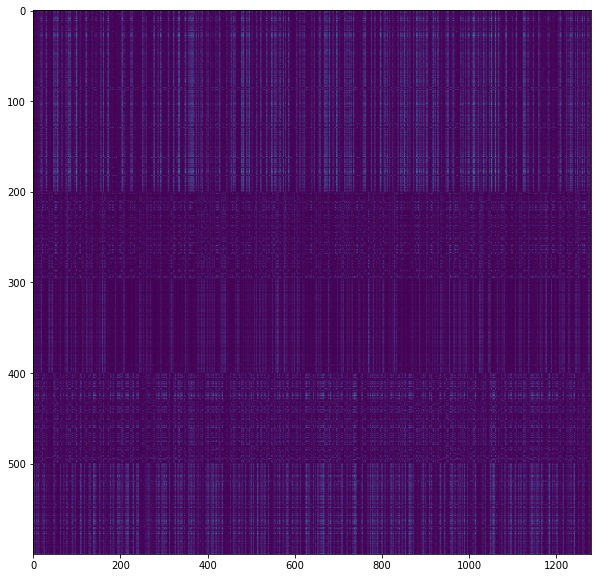

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(tst['val_src']['feature'].astype(float), aspect='auto')

In [16]:
tst['val_src']['feature'].shape

(600, 1280)

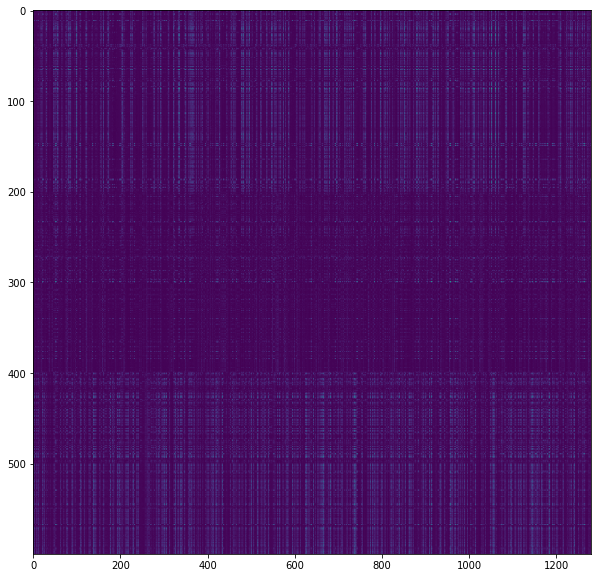

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(tst['val_tgt']['feature'].astype(float), aspect='auto')